In [14]:
import tensorflow as tf
import PIL.Image
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm
import skimage
import skimage.io

In [3]:
mano_js = json.load( open('archive-3/training_mano.json') )
k_js = json.load( open('archive-3/training_K.json') )
scale_js = json.load( open('archive-3/training_scale.json') )
verts_js = json.load( open('archive-3/training_verts.json') )
xyz_js = json.load( open('archive-3/training_xyz.json') )

In [4]:
xyz_js = np.array( xyz_js )
k_js = np.array( k_js )

In [5]:
k_js.shape, xyz_js.shape

((32560, 3, 3), (32560, 21, 3))

In [9]:
def generate_coordinates( id_img, k_js, xyz_js ):
    coords_1 = np.matmul( k_js[ id_img ], xyz_js.T).T
    uv_1 = coords_1[:, :2]/coords_1[:, -1:]
    uv_1 = np.round(uv_1).astype('int')
    return uv_1

def generate_labeled_image( im_1, uv_1 ):
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19,20]]
    
    colors_vertex = [ (0,0,0), (0,200,100), (50,50,250), (200,0,0), (255,255,50), (0,100,100), (100,170,255),
                      (255,50,150), (130,130,60),(150,250,50), (10,130,200), (190,0,70),  (220,180, 0), (20,100,40), 
                      (60,10,150), (140,0,40), (240,160,0), (0,200,160),  (90,100,170), (150,0,70),(220,200,70)]
    
    for c in connections:
        im_1 = cv2.line( im_1, uv_1[c[0]], uv_1[c[1]], (255,255,255), 2)
    for p_i, point in enumerate(uv_1):
        im_1 = cv2.circle( im_1, point, 2, colors_vertex[ p_i ], -1)
    return im_1

[ WARN:0@92.542] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('archive-3/training/rgb/0000008.jpg'): can't open/read file: check file path/integrity


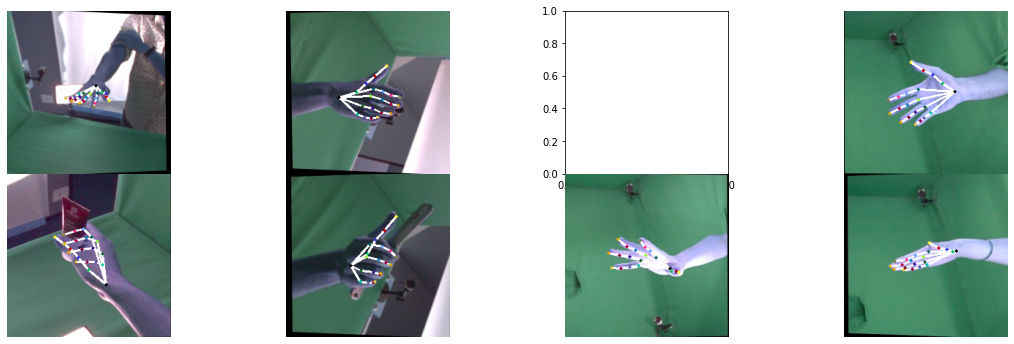

In [10]:
fig_1 = plt.figure( figsize = (20, 6) )

for i, id_img in enumerate(np.random.randint( low = 0, high = 99, size = 8 )):
    #print(id_img)
    try:
        im_1 = cv2.imread( f"archive-3/training/rgb/000000{id_img}.jpg" )
        uv_1 = generate_coordinates( id_img, k_js, xyz_js[ id_img ] )
        im_1 = generate_labeled_image( im_1, uv_1 )

        ax_i = fig_1.add_subplot( 2, 4, i+1 )
        ax_i.imshow(im_1)
        ax_i.axis('off')
    except:
        pass
fig_1.subplots_adjust(wspace=0, hspace=0)

In [11]:
im_1.shape

(224, 224, 3)

In [12]:
np.max(xyz_js)

1.0428340435028076

## It doesn't work to predict the coordinates, better to predict the point maps

In [23]:


def hand_pose_model( input_shape ):
    input_x = Input( shape = input_shape )
    x = Conv2D( filters = 36, kernel_size = 3, activation = 'relu', name = 'conv_1' )( input_x )
    x = MaxPooling2D( pool_size = (2, 2), name = 'maxpool_1' )( x )
    x = Dropout( 0.7, name = 'dropout_1' )( x )
    x = Conv2D( filters = 18, kernel_size = 8, activation = 'relu', name = 'conv_2' )( x )
    x = MaxPooling2D( pool_size = (2, 2), name = 'maxpool_2' )( x )
    x = Dropout( 0.7, name = 'dropout_2' )( x )
    x = Conv2D( filters = 6, kernel_size = 12, activation = 'relu', name = 'conv_3' )( x )
    x = Flatten( name = 'flatten_1' )( x )
    x = Dropout( 0.7, name = 'dropout_3' )( x )
    x = BatchNormalization( )(x)
    x = Dense( 128, activation = 'relu', name = 'dense_1' )( x )
    y_hat = Dense( 63, name = 'dense_out' )( x )
    
    model = Model( inputs = input_x, outputs = y_hat, name = 'hand_pose_model' )
    
    return model

def hand_pose_model( input_shape ):
    input_x = Input( shape = input_shape )
    #x = BatchNormalization( )( input_x )
    x = Dropout( 0.7, name = 'dropout_1' )( input_x )
    x = Conv2D( filters = 16, kernel_size = 3, activation = 'relu', name = 'conv_1' )( x )
    x = BatchNormalization( )(x)
    x = Dropout( 0.7, name = 'dropout_2' )( x )
    x = Conv2D( filters = 16, kernel_size = 3, activation = 'relu', name = 'conv_2' )( x )
    x = MaxPooling2D( pool_size = (2, 2), name = 'maxpool_1' )( x )
    
  
    x = BatchNormalization( )( x )
    x = Dropout( 0.7, name = 'dropout_3' )( x )
    x = Conv2D( filters = 32, kernel_size = 3, activation = 'relu', name = 'conv_3' )( x )
    x = BatchNormalization( )(x)
    x = Dropout( 0.7, name = 'dropout_4' )( x )
    x = Conv2D( filters = 32, kernel_size = 3, activation = 'relu', name = 'conv_4' )( x )
    x = MaxPooling2D( pool_size = (2, 2), name = 'maxpool_2' )( x )

    
    x = Flatten( name = 'flatten_1' )( x )
    
    x = Dropout( 0.7, name = 'dropout_5' )( x )
    x = Dense( 128, activation = 'relu', name = 'dense_1' )( x )
    y_hat = Dense( 63, name = 'dense_out' )( x )
    
    model = Model( inputs = input_x, outputs = y_hat, name = 'hand_pose_model' )
    
    return model

In [24]:
input_shape = (224, 224, 3)
cnn_model = hand_pose_model( input_shape )

In [25]:
cnn_model.summary()

Model: "hand_pose_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 dropout_1 (Dropout)         (None, 224, 224, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 16)     64        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 222, 222, 16)      0         
                                                                 
 conv_2 (Conv2D)             (None, 220, 220, 16)      2320      
                                                   

In [328]:
plot_model( cnn_model, show_shapes = True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [26]:
cnn_model.compile( optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mean_squared_error')#MeanSquaredError()  )

In [27]:
#train_datagen = ImageDataGenerator( rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True )
#test_datagen = ImageDataGenerator( rescale = 1./255 )

#train_generator = train_datagen.flow_from_directory( 'archive-3/training', target_size = (224, 224),
#                                                     batch_size = 64, class_mode = None)
#validation_generator = test_datagen.flow_from_directory( 'archive-3/training', target_size = (224, 224),
#                                                     batch_size = 64, class_mode = None)

In [28]:
def _int64_feature( value ):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature( value ):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# images and labels array as input
def convert_to( images, labels, name ):
    num_examples = labels.shape[0]
    if images.shape[0] != num_examples:
        raise ValueError("Images size %d does not match label size %d." %
                     (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    filename = os.path.join(FLAGS.directory, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example( features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'label': _bytes_feature( labels[index] ),
            #'label': _int64_feature(int(labels[index])),
            'image_raw': _bytes_feature(image_raw)}) )
        writer.write( example.SerializeToString() )
        
def read_image(file_name, images_path):
    image = skimage.io.imread(images_path + file_name)
    return image

In [29]:
images_path = "archive-3/training/rgb/"
image_list = os.listdir(images_path)

In [39]:
X_images = []
Y_coords = []
for img_name in image_list[:1000]:
    id_img = int(img_name.split('.')[0])
    if id_img < len(xyz_js):
        try:
            im_1 = cv2.imread( images_path + img_name )
            print(img_name)
            X_images.append( im_1 )
            Y_coords.append( xyz_js[ id_img ].reshape( 63 ) )
            #Y_coords.append( xyz_js[ id_img ][0][0] )
        except:
            #print(img_name)
            pass

X_images = np.array( X_images )/255
Y_coords = np.array( Y_coords  )

00013326.jpg
00014449.jpg
00003135.jpg
00015757.jpg
00004882.jpg
00005544.jpg
00025694.jpg
00012038.jpg
00011531.jpg
00020934.jpg
00001722.jpg
00018273.jpg
00017140.jpg
00031839.jpg
00027083.jpg
00008060.jpg
00007353.jpg
00008706.jpg
00010149.jpg
00030299.jpg
00007435.jpg
00018515.jpg
00029910.jpg
00017626.jpg
00001044.jpg
00021394.jpg
00016538.jpg
00011257.jpg
00009418.jpg
00031187.jpg
00005222.jpg
00015031.jpg
00023583.jpg
00003653.jpg
00012986.jpg
00022845.jpg
00013440.jpg
00005236.jpg
00022689.jpg
00015025.jpg
00002559.jpg
00023597.jpg
00012992.jpg
00003647.jpg
00022851.jpg
00004128.jpg
00013454.jpg
00008712.jpg
00007421.jpg
00018501.jpg
00017632.jpg
00029904.jpg
00001050.jpg
00027929.jpg
00021380.jpg
00011243.jpg
00031193.jpg
00026389.jpg
00011525.jpg
00020920.jpg
00006059.jpg
00001736.jpg
00019179.jpg
00018267.jpg
00000428.jpg
00017154.jpg
00008074.jpg
00027097.jpg
00007347.jpg
00013332.jpg
00003121.jpg
00025858.jpg
00004896.jpg
00015743.jpg
00005550.jpg
00025680.jpg
00029092.jpg

In [31]:
X_images.shape, Y_coords.shape

((251, 224, 224, 3), (251, 63))

In [32]:
training_history = cnn_model.fit( X_images, Y_coords, batch_size = 16, epochs = 100, validation_split = 0.3 )

Epoch 1/100


2022-08-13 18:37:28.203783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-13 18:37:28.582917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 238.2221

2022-08-13 18:37:34.765510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 7s 375ms/step - loss: 238.2221 - val_loss: 0.1570
Epoch 2/100
11/11 [==============================] - 2s 177ms/step - loss: 0.1575 - val_loss: 0.1569
Epoch 3/100
11/11 [==============================] - 2s 164ms/step - loss: 0.1572 - val_loss: 0.1565
Epoch 4/100
11/11 [==============================] - 2s 165ms/step - loss: 0.1749 - val_loss: 0.1559
Epoch 5/100
11/11 [==============================] - 2s 168ms/step - loss: 0.1561 - val_loss: 0.1553
Epoch 6/100
11/11 [==============================] - 2s 170ms/step - loss: 0.1554 - val_loss: 0.1545
Epoch 7/100
11/11 [==============================] - 2s 163ms/step - loss: 0.1547 - val_loss: 0.1537
Epoch 8/100
11/11 [==============================] - 2s 163ms/step - loss: 0.1539 - val_loss: 0.1529
Epoch 9/100
11/11 [==============================] - 2s 164ms/step - loss: 0.1530 - val_loss: 0.1520
Epoch 10/100
11/11 [==============================] - 2s 166ms/step - loss: 0.1521 - val_loss: 0.1511

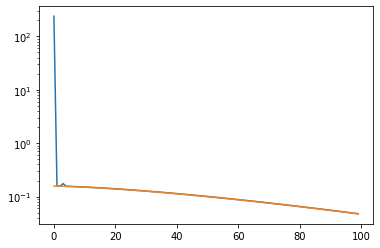

In [34]:
plt.plot( training_history.history['loss'] )
plt.plot( training_history.history['val_loss'] )
plt.yscale('log')

In [35]:
training_history_2 = cnn_model.fit( X_images, Y_coords, batch_size = 16, epochs = 100, validation_split = 0.3 )

Epoch 1/100
11/11 [==============================] - 2s 178ms/step - loss: 0.0469 - val_loss: 0.0466
Epoch 2/100
11/11 [==============================] - 2s 168ms/step - loss: 0.0461 - val_loss: 0.0458
Epoch 3/100
11/11 [==============================] - 2s 163ms/step - loss: 0.0453 - val_loss: 0.0450
Epoch 4/100
11/11 [==============================] - 2s 173ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 5/100
11/11 [==============================] - 2s 167ms/step - loss: 0.0438 - val_loss: 0.0435
Epoch 6/100
11/11 [==============================] - 2s 164ms/step - loss: 0.0430 - val_loss: 0.0428
Epoch 7/100
11/11 [==============================] - 2s 163ms/step - loss: 0.0423 - val_loss: 0.0421
Epoch 8/100
11/11 [==============================] - 2s 165ms/step - loss: 0.0415 - val_loss: 0.0413
Epoch 9/100
11/11 [==============================] - 2s 163ms/step - loss: 0.0408 - val_loss: 0.0406
Epoch 10/100
11/11 [==============================] - 2s 163ms/step - loss: 0.0401 - val_lo

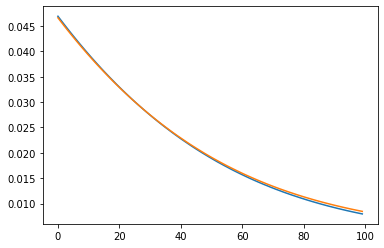

In [36]:
plt.plot( training_history_2.history['loss'] )
plt.plot( training_history_2.history['val_loss'] )
#plt.yscale('log')

In [37]:
training_history_3 = cnn_model.fit( X_images, Y_coords, batch_size = 16, epochs = 200, validation_split = 0.3 )

Epoch 1/200
11/11 [==============================] - 2s 184ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 2/200
11/11 [==============================] - 2s 165ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 3/200
11/11 [==============================] - 2s 162ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 4/200
11/11 [==============================] - 2s 165ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 5/200
11/11 [==============================] - 2s 164ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 6/200
11/11 [==============================] - 2s 165ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 7/200
11/11 [==============================] - 2s 162ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 8/200
11/11 [==============================] - 2s 162ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 9/200
11/11 [==============================] - 2s 164ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 10/200
11/11 [==============================] - 2s 163ms/step - loss: 0.0069 - val_lo

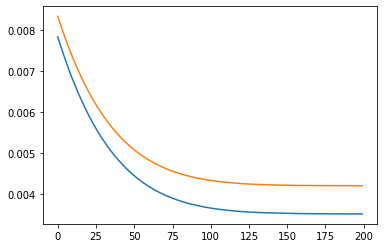

In [38]:
plt.plot( training_history_3.history['loss'] )
plt.plot( training_history_3.history['val_loss'] )
#plt.yscale('log')

## Testing

In [41]:
k_js_test = np.array( json.load( open('archive-3/evaluation_K.json') ) )

k_js_test =  k_js.copy()

In [43]:
#coords_1 = np.matmul( k_js[ id_img ], xyz_js[ id_img ].T).T

1/1 [==============================] - 0s 12ms/step


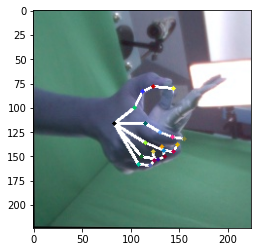

In [57]:
#test_img_name = 'archive-3/evaluation/rgb/00000042.jpg'

test_img_name = 'archive-3/training/rgb/00031805.jpg'

id_img_test = int(test_img_name.split('.')[0].split('/')[-1])
im_test = cv2.imread( test_img_name )

im_test_1 = np.array( [im_test] )
xyz_predicted = cnn_model.predict( im_test_1 )
xyz_predicted = xyz_predicted.reshape( 21,3 )


uv_test = generate_coordinates( id_img_test, k_js_test, xyz_js[ id_img_test ] )
im_test = generate_labeled_image( im_test, uv_test )

fig_2 = plt.figure()
ax_i = fig_2.add_subplot( 1, 1, 1 )
ax_i.imshow(im_test)
#ax_i.axis('off')


In [58]:
xyz_js[ id_img_test ]

array([[-3.37753668e-02,  4.03488288e-03,  7.91321337e-01],
       [-9.24832374e-03, -1.33906435e-02,  7.71905422e-01],
       [-3.81618738e-04, -3.18389684e-02,  7.51967788e-01],
       [ 1.15055814e-02, -3.58199477e-02,  7.35580325e-01],
       [ 3.31571624e-02, -3.32196727e-02,  7.18794286e-01],
       [ 3.58802825e-03,  4.25498141e-03,  7.22343504e-01],
       [ 1.84984282e-02,  1.29184788e-02,  7.04326689e-01],
       [ 3.15784588e-02,  1.83257908e-02,  7.07556307e-01],
       [ 4.55016121e-02,  2.04282459e-02,  7.22963035e-01],
       [ 3.58629227e-03,  2.48162523e-02,  7.23428249e-01],
       [ 2.34660134e-02,  3.37399617e-02,  7.21204460e-01],
       [ 3.35966423e-02,  3.49652320e-02,  7.33374298e-01],
       [ 3.92531380e-02,  2.86270455e-02,  7.53387094e-01],
       [-1.24231726e-03,  4.09113914e-02,  7.37275481e-01],
       [ 1.70375332e-02,  4.39229533e-02,  7.36895680e-01],
       [ 2.45746151e-02,  4.15499806e-02,  7.51489878e-01],
       [ 2.21561119e-02,  3.16649154e-02

In [59]:
xyz_predicted

array([[ 4.33408190e-03,  1.76720526e-02,  6.78277671e-01],
       [ 2.37391889e-03,  7.26024806e-03,  6.80055678e-01],
       [ 7.42891047e-04, -3.24560283e-03,  6.78799987e-01],
       [-1.55243557e-04, -8.42238404e-03,  6.75630867e-01],
       [-6.09747774e-04, -1.43435560e-02,  6.77090228e-01],
       [ 2.49545294e-04, -1.14833955e-02,  6.78204894e-01],
       [-3.01224907e-04, -1.53902434e-02,  6.77909255e-01],
       [-1.24663243e-03, -1.44214695e-02,  6.73306584e-01],
       [-1.84048945e-03, -1.32222539e-02,  6.78055465e-01],
       [ 6.64820254e-04, -5.52842254e-03,  6.79003417e-01],
       [-9.73259739e-06, -7.20194448e-03,  6.77222431e-01],
       [-8.86719354e-05, -5.66702941e-03,  6.77891135e-01],
       [-7.72631203e-04, -5.03995270e-03,  6.76778257e-01],
       [ 1.73729740e-03,  5.83293382e-03,  6.80236161e-01],
       [ 1.23508181e-03,  2.88122753e-03,  6.79474652e-01],
       [ 1.27273356e-03,  4.25186707e-03,  6.78244948e-01],
       [ 1.20975985e-03,  4.98517742e-03

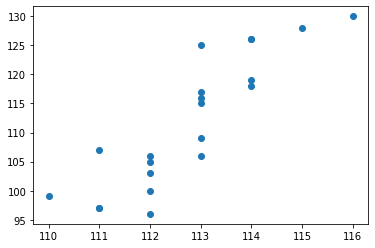

In [51]:
plt.scatter( uv_test[:,0], uv_test[:,1] )

In [52]:
xyz_predicted

array([[ 4.33408190e-03,  1.76720526e-02,  6.78277671e-01],
       [ 2.37391889e-03,  7.26024806e-03,  6.80055678e-01],
       [ 7.42891047e-04, -3.24560283e-03,  6.78799987e-01],
       [-1.55243557e-04, -8.42238404e-03,  6.75630867e-01],
       [-6.09747774e-04, -1.43435560e-02,  6.77090228e-01],
       [ 2.49545294e-04, -1.14833955e-02,  6.78204894e-01],
       [-3.01224907e-04, -1.53902434e-02,  6.77909255e-01],
       [-1.24663243e-03, -1.44214695e-02,  6.73306584e-01],
       [-1.84048945e-03, -1.32222539e-02,  6.78055465e-01],
       [ 6.64820254e-04, -5.52842254e-03,  6.79003417e-01],
       [-9.73259739e-06, -7.20194448e-03,  6.77222431e-01],
       [-8.86719354e-05, -5.66702941e-03,  6.77891135e-01],
       [-7.72631203e-04, -5.03995270e-03,  6.76778257e-01],
       [ 1.73729740e-03,  5.83293382e-03,  6.80236161e-01],
       [ 1.23508181e-03,  2.88122753e-03,  6.79474652e-01],
       [ 1.27273356e-03,  4.25186707e-03,  6.78244948e-01],
       [ 1.20975985e-03,  4.98517742e-03

In [392]:
uv_test

array([[   60,  -576],
       [ 2062, -1545],
       [-4093,  -502],
       [-4417,  1199],
       [  745,  -824],
       [-2271,  3698],
       [ -622,   355],
       [-2168,  1764],
       [  263,   -40],
       [  673, -1315],
       [-1011,    58],
       [ -959,   477],
       [  470,  -663],
       [ -238,   519],
       [  753,  -334],
       [ -370,   -23],
       [  457,   -23],
       [ -199,   544],
       [ -120,   -54],
       [   44,   -77],
       [-1049,  1917]])

In [396]:
xyz_js.min()

-0.13515593111515045

In [397]:
xyz_js.max()

1.0428340435028076

In [399]:
scale_js

[0.03377968912811258,
 0.02939691576515436,
 0.03057376521645858,
 0.024140301846520204,
 0.029215371048135024,
 0.02914327268247806,
 0.03192878667154908,
 0.03364934451390801,
 0.024021977940648854,
 0.034865311054958194,
 0.023197537397855204,
 0.03260123282360093,
 0.027915261606071218,
 0.020312248604426562,
 0.024903584615105508,
 0.030228599757066394,
 0.02558407366436204,
 0.025794451548569727,
 0.024129032010841787,
 0.017714933940241318,
 0.019705261896218792,
 0.029593081947919545,
 0.03471425872684371,
 0.0334732834334712,
 0.028731681897702376,
 0.03088185861265852,
 0.02253200370996748,
 0.032937637550292234,
 0.027923666664343788,
 0.02975211078074174,
 0.023574606392956172,
 0.02594241830792482,
 0.03303570303189041,
 0.03277817867372859,
 0.03377737738852263,
 0.03191526620784117,
 0.03418704372788066,
 0.03250452390668756,
 0.019066803714352147,
 0.027384457847225617,
 0.03072937703277823,
 0.02423097411096457,
 0.029413599527065452,
 0.02984980509413836,
 0.018413428